In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc
import pickle
from anndata import AnnData
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

/home/xiaojiashun/anaconda3/envs/SpatialScope/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Brain cortex smartseq reference
Download the public smartseq from: https://datasets.cellxgene.cziscience.com/77a91ab6-4fcc-428d-b719-a3f1238df262.h5ad.

## Get reference sample
For Cibersortx to calculate signature matrix

In [117]:
t0 = time.time()
adata = sc.read('../data/brain_scRNAseq/cortex_smartseq_ori.h5ad')
print(f'Time loading h5ad: {time.time() - t0:.1f}s')
adata

Time loading h5ad: 40.1s


AnnData object with n_obs × n_vars = 49417 × 35812
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'cortical_layer_colors', 'region_colors', 'schema_reference', 'schema_version', 'titl

In [118]:
celltype_map = {
    'astrocyte': 'Astrocytes',
    'endothelial cell': 'Endothelial',
    'glutamatergic neuron': 'Excitatory neurons',
    'L2/3-6 intratelencephalic projecting glutamatergic cortical neuron': 'Excitatory neurons',
    'L5 extratelencephalic projecting glutamatergic cortical neuron': 'Excitatory neurons',
    'near-projecting glutamatergic cortical neuron': None,
    'L6 corticothalamic-projecting glutamatergic cortical neuron': 'Excitatory neurons',
    'L6b glutamatergic cortical neuron': 'Excitatory neurons',
    'lamp5 GABAergic cortical interneuron': 'Inhibitory neurons',
    'microglial cell': 'Microglia',
    'oligodendrocyte precursor cell': 'OPCs',
    'oligodendrocyte': 'Oligodendrocytes',
    'caudal ganglionic eminence derived GABAergic cortical interneuron': 'Inhibitory neurons',
    'pvalb GABAergic cortical interneuron': 'Inhibitory neurons',
    'pericyte': 'Pericytes',
    'sst GABAergic cortical interneuron': 'Inhibitory neurons',
    'vip GABAergic cortical interneuron': 'Inhibitory neurons',
    'vascular leptomeningeal cell': None,
    'native cell': None
}
pd.DataFrame({'cell_type': list(celltype_map.keys()), 'celltype_lowres': list(celltype_map.values())})

cell_type     celltype_lowres
0                                           astrocyte          Astrocytes
1                                    endothelial cell         Endothelial
2                                glutamatergic neuron  Excitatory neurons
3   L2/3-6 intratelencephalic projecting glutamate...  Excitatory neurons
4   L5 extratelencephalic projecting glutamatergic...  Excitatory neurons
5       near-projecting glutamatergic cortical neuron                None
6   L6 corticothalamic-projecting glutamatergic co...  Excitatory neurons
7                   L6b glutamatergic cortical neuron  Excitatory neurons
8                lamp5 GABAergic cortical interneuron  Inhibitory neurons
9                                     microglial cell           Microglia
10                     oligodendrocyte precursor cell                OPCs
11                                    oligodendrocyte    Oligodendrocytes
12  caudal ganglionic eminence derived GABAergic c...  Inhibitory neurons
13               pvalb GABAergic cortical interneuron  Inhibitory neurons
14                                           pericyte           Pericytes
15                 sst GABAergic cortical interneuron  Inhibitory neurons
16                 vip GABAergic cortical interneuron  Inhibitory neurons
17                       vascular leptomeningeal cell                None
18                                        native cell                None

In [119]:
adata.obs['celltype_lowres'] = adata.obs.cell_type.map(celltype_map)
adata = adata[~adata.obs.celltype_lowres.isnull()]
adata

View of AnnData object with n_obs × n_vars = 46605 × 35812
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'celltype_lowres'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'cortical_layer_colors', 'region_colors', 'schema_referenc

In [120]:
## subsample
adata = adata[adata.obs.index.isin(adata.obs.groupby('celltype_lowres').apply(
    lambda x: x.sample(frac=3000/x.shape[0],replace=False) if x.shape[0]>3000 else x).reset_index(level=0,drop=True).index)].copy()

In [121]:
adata

AnnData object with n_obs × n_vars = 10742 × 35812
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'celltype_lowres'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'cortical_layer_colors', 'region_colors', 'schema_reference', 'sch

409205.0


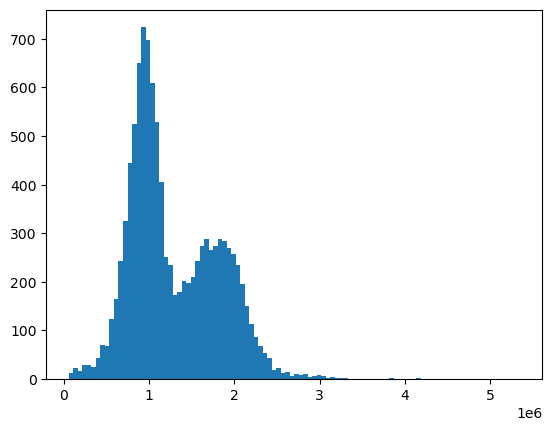

In [122]:
print(adata.X.max())
plt.hist(adata.X.sum(1),bins=100)
plt.show()

In [123]:
cell_type_column = 'celltype_lowres'

sc.pp.filter_cells(adata, min_counts=3000)
sc.pp.filter_cells(adata, max_counts=3e6)
adata = adata[:,~np.array([_.startswith('MT-') for _ in adata.var.index])]
adata = adata[:,~np.array([_.startswith('mt-') for _ in adata.var.index])]

adata.X.max(), adata.shape

(335587.0, (10705, 35812))

In [49]:
adata.write('../data/brain_scRNAseq/cortex_smartseq_subsample.h5ad')

In [125]:
adata.raw = adata.copy()
sc.pp.normalize_total(adata, inplace=True)
adata.X.max()

220925.23

In [126]:
adata.obs.head()

suspension_type                cluster      class  \
F2S4_160113_027_B01         nucleus      Inh L2-5 VIP TOX2  GABAergic   
F2S4_160113_027_G01         nucleus   Inh L1-4 LAMP5 DUSP4  GABAergic   
F2S4_160113_029_A01         nucleus      Inh L1 PAX6 GRIP2  GABAergic   
F2S4_160113_029_B01         nucleus      Inh L1 LAMP5 NDNF  GABAergic   
F2S4_160113_029_G01         nucleus  Inh L1-2 VIP PPAPDC1A  GABAergic   

                    subclass sex_ontology_term_id region cortical_layer  \
F2S4_160113_027_B01      VIP         PATO:0000384    MTG             L1   
F2S4_160113_027_G01    LAMP5         PATO:0000384    MTG             L1   
F2S4_160113_029_A01     PAX6         PATO:0000384    MTG             L1   
F2S4_160113_029_B01    LAMP5         PATO:0000384    MTG             L1   
F2S4_160113_029_G01      VIP         PATO:0000384    MTG             L1   

                    cell_type_accession        cell_type_alias  \
F2S4_160113_027_B01        CS1910121032      Inh L2-5 VIP TOX2   
F2S4_160113_027_G01        CS1910121003   Inh L1-4 LAMP5 DUSP4   
F2S4_160113_029_A01        CS1910121010      Inh L1 PAX6 GRIP2   
F2S4_160113_029_B01        CS1910121001      Inh L1 LAMP5 NDNF   
F2S4_160113_029_G01        CS1910121022  Inh L1-2 VIP PPAPDC1A   

                    cell_type_alt_alias  ...         assay disease  \
F2S4_160113_027_B01                 NaN  ...  Smart-seq v4  normal   
F2S4_160113_027_G01       Lamp5 Rosehip  ...  Smart-seq v4  normal   
F2S4_160113_029_A01                 NaN  ...  Smart-seq v4  normal   
F2S4_160113_029_B01                 NaN  ...  Smart-seq v4  normal   
F2S4_160113_029_G01                 NaN  ...  Smart-seq v4  normal   

                         organism   sex                 tissue  \
F2S4_160113_027_B01  Homo sapiens  male  middle temporal gyrus   
F2S4_160113_027_G01  Homo sapiens  male  middle temporal gyrus   
F2S4_160113_029_A01  Homo sapiens  male  middle temporal gyrus   
F2S4_160113_029_B01  Homo sapiens  male  middle temporal gyrus   
F2S4_160113_029_G01  Homo sapiens  male  middle temporal gyrus   

                    self_reported_ethnicity        development_stage  \
F2S4_160113_027_B01                European  50-year-old human stage   
F2S4_160113_027_G01                European  50-year-old human stage   
F2S4_160113_029_A01                European  50-year-old human stage   
F2S4_160113_029_B01                European  50-year-old human stage   
F2S4_160113_029_G01                European  50-year-old human stage   

                     observation_joinid     celltype_lowres   n_counts  
F2S4_160113_027_B01          g~daSNKdwS  Inhibitory neurons  1649220.0  
F2S4_160113_027_G01          )*uC}VIKq%  Inhibitory neurons  1045315.0  
F2S4_160113_029_A01          Y}(TaLuw9z  Inhibitory neurons  1852480.0  
F2S4_160113_029_B01          Ez8pjCbg1?  Inhibitory neurons  1716370.0  
F2S4_160113_029_G01          $Q3SyXAU`U  Inhibitory neurons  1656029.0  

[5 rows x 40 columns]

In [127]:
sc.pp.log1p(adata)

12.305584


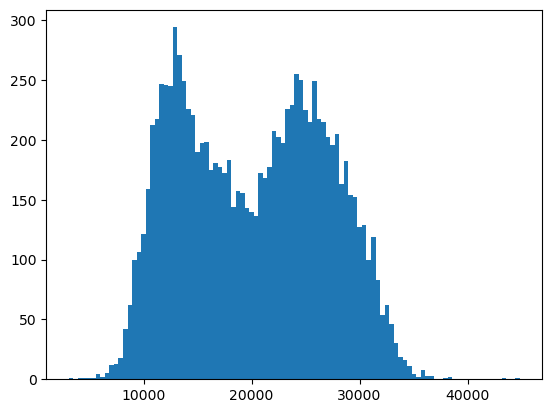

In [128]:
print(adata.X.max())
plt.hist(adata.X.sum(1),bins=100)
plt.show()

In [131]:
obs = adata.obs
obs['celltype_lowres'] = obs['celltype_lowres'].astype(str)
obs['id'] = obs.groupby('celltype_lowres').cumcount().astype(str)
obs['name'] = obs[['celltype_lowres', 'id']].agg('.'.join, axis=1)
X = adata.X
arr = X.toarray()
df = pd.DataFrame(data=arr.T, columns=obs['name'].values)
df.insert(0, 'Gene', adata.var.index)
print(df.shape)

(35812, 10706)


In [132]:
df_sig = df.loc[df.Gene.isin(sigmat.GeneSymbol)]
print(df_sig.shape)

(1379, 10706)


In [133]:
## reference sample for cibersortx to calculate signature matrix
df_sig.to_csv('../data/cibersortx/brain_smartseq_subsample_siggenes_GEP.txt.gz', sep='\t', compression='gzip', index=False)

## RNA-seq visualization

In [32]:
t0 = time.time()
sc.tl.rank_genes_groups(adata, groupby=cell_type_column, method='t-test', use_raw=False)
t1 = time.time()
print(f'Time selecting signature gene: {t1 - t0:.2f}s')

Time selecting signature gene: 9.27s


In [33]:
markers_df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).iloc[0:500, :]
markers = list(np.unique(markers_df.melt().value.values))
print(len(markers))

3104


In [35]:
adata.var.loc[adata.var.index.isin(markers),'Marker'] = True
adata.var['Marker'] = adata.var['Marker'].fillna(False)
adata.var['highly_variable'] = adata.var['Marker']

t0 = time.time()
sc.pp.pca(adata,svd_solver='arpack', n_comps=20, use_highly_variable=True)
t1 = time.time()
print(f'Time pca: {t1 - t0:.2f}s')
adata.X.max()

Time pca: 6.17s


12.299769

In [36]:
t0 = time.time()
sc.pp.neighbors(adata, metric='cosine', n_neighbors=30, n_pcs = 20)
sc.tl.umap(adata, min_dist = 0.5, spread = 1, maxiter=60)
t1 = time.time()
print(f'Time umap: {t1 - t0:.2f}s')

Time umap: 13.72s


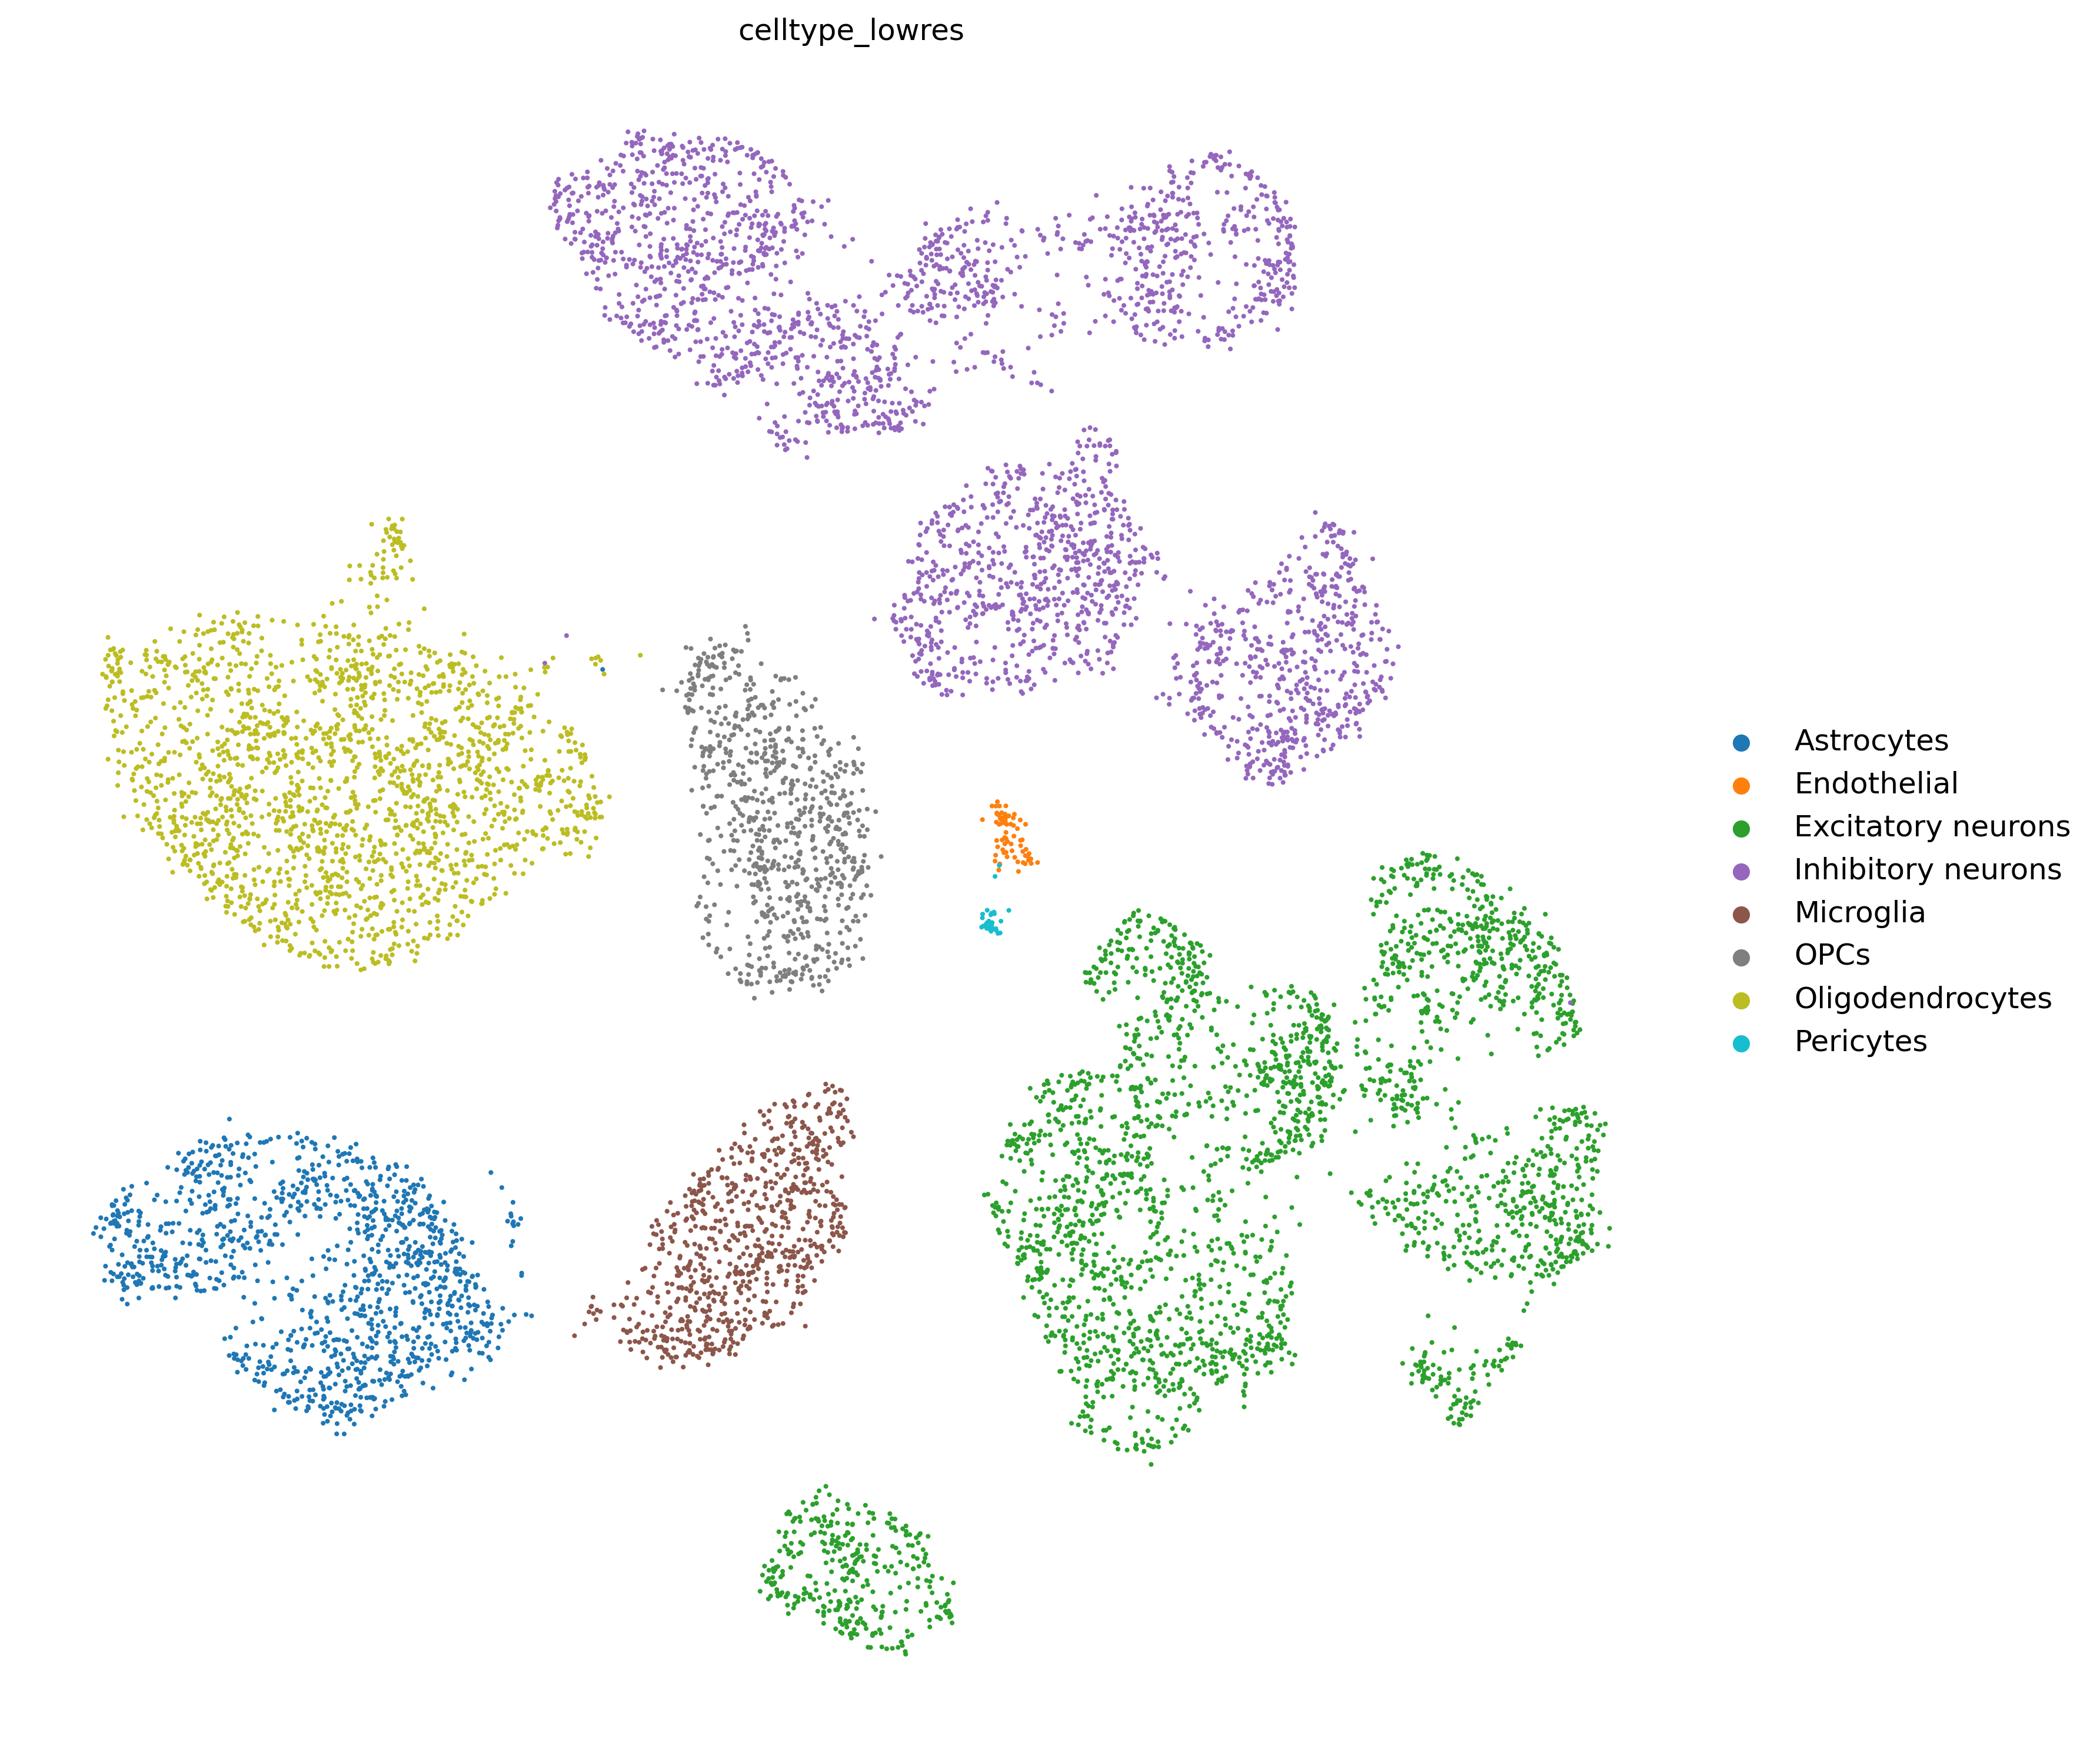

In [37]:
with plt.rc_context({'figure.figsize': (12, 10), 'figure.dpi': 300}):
    sc.pl.umap(
        adata, color='celltype_lowres', size=15, frameon=False, show=False, 
        palette='tab10', legend_loc='right margin', legend_fontsize='large', legend_fontweight='medium'
    )
plt.tight_layout()
# plt.savefig(f'data/1M_SCT_counts/1m_{version}_umap.png')

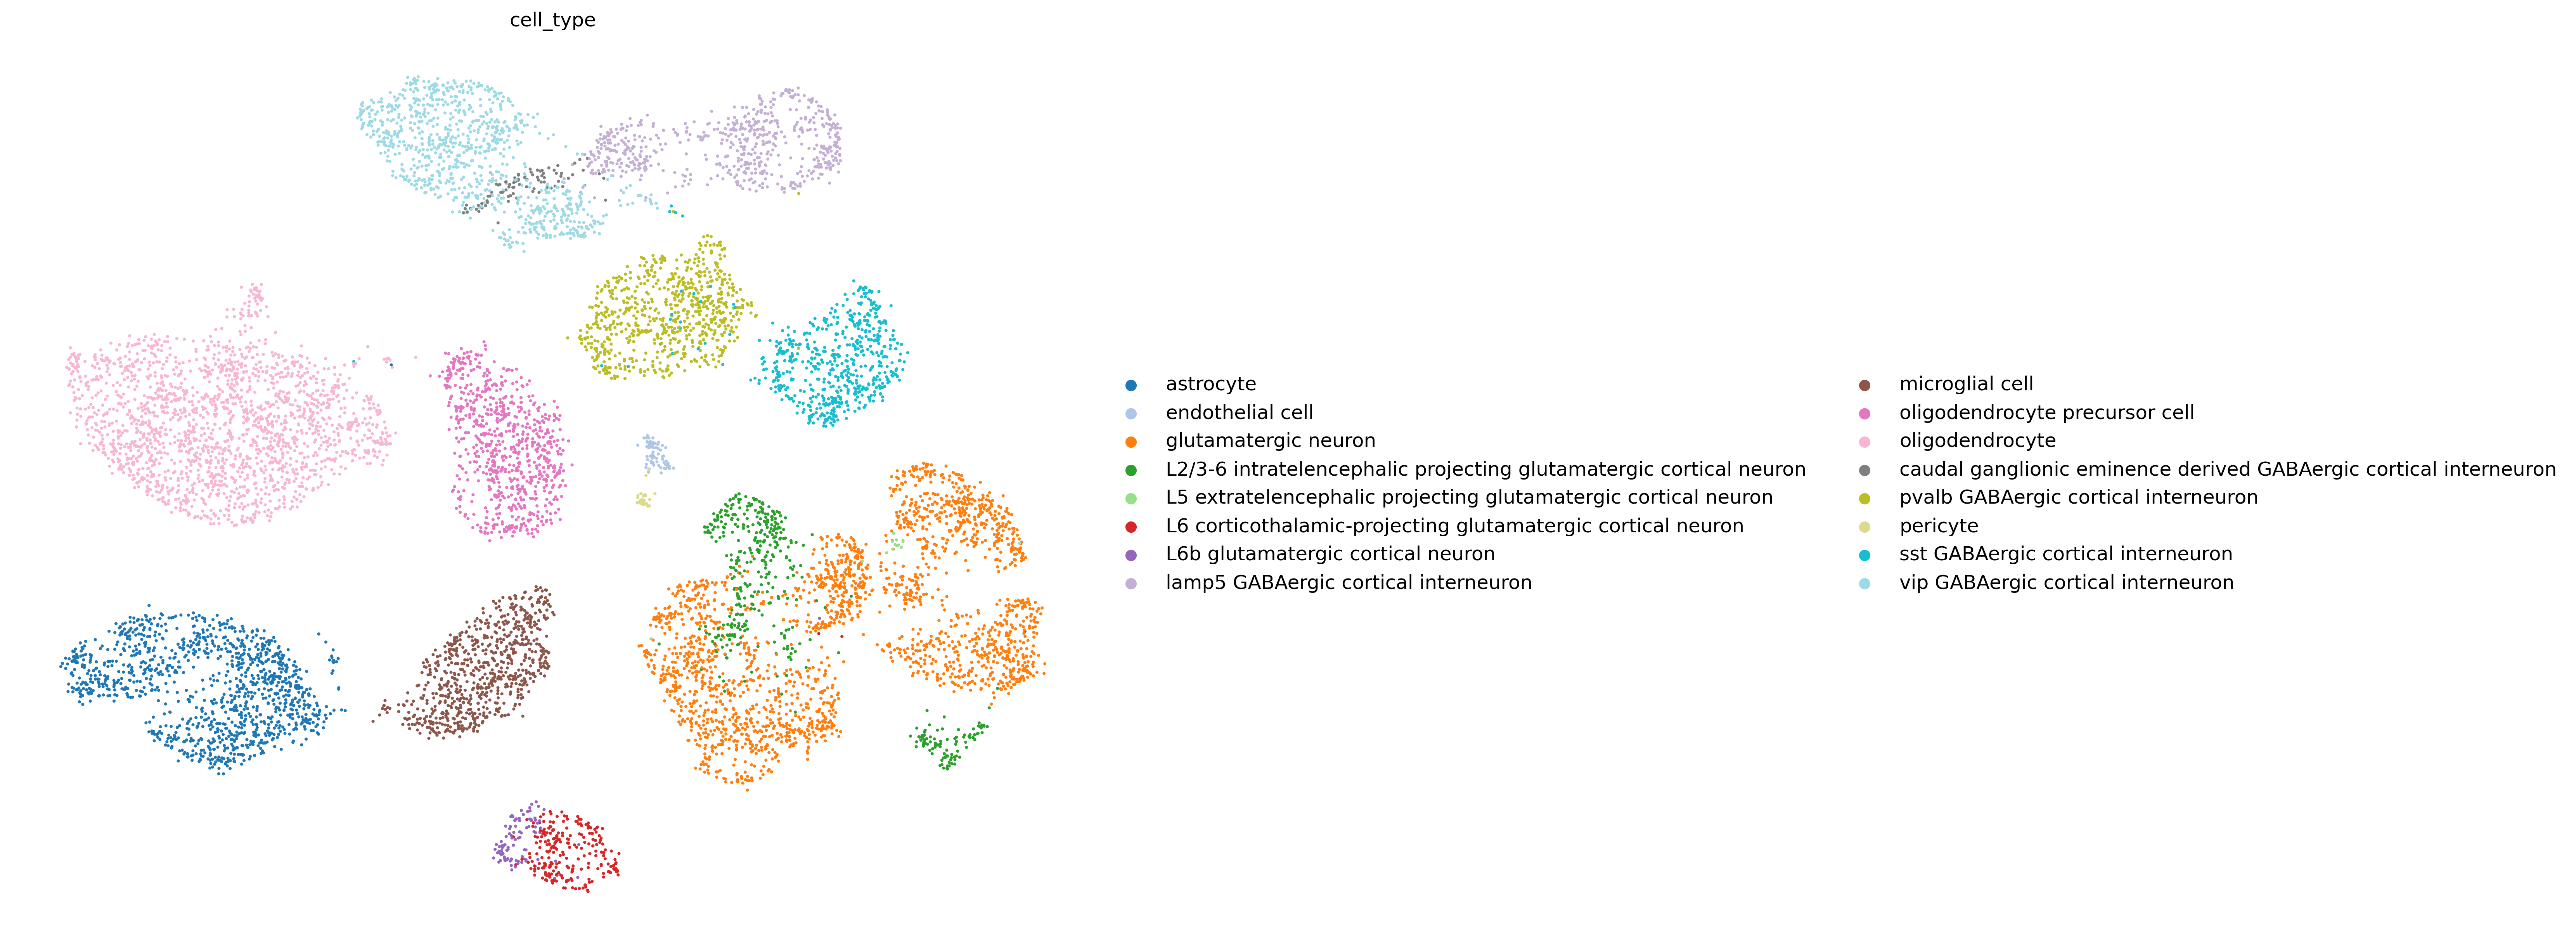

In [38]:
with plt.rc_context({'figure.figsize': (12, 10), 'figure.dpi': 300}):
    sc.pl.umap(
        adata, color='cell_type', size=15, frameon=False, show=False, 
        palette='tab20', legend_loc='right margin', legend_fontsize='large', legend_fontweight='medium'
    )
plt.tight_layout()

# Create GTEx mixture file

In [7]:
## mixture file
gtex = pd.read_csv('../data/GTEx/brain_cortex/bulk-gex_v8_rna-seq_tpms-by-tissue_gene_tpm_2017-06-05_v8_brain_cortex.gct.gz', sep='\t', compression='gzip', skiprows=[0,1])
print(gtex.shape)

(56200, 258)


In [13]:
gtex.insert(3, 'GeneSymbol', gtex.Name.map(lambda x: x.split('.')[0]))

In [14]:
gtex.head()

id               Name  Description       GeneSymbol  \
0   0  ENSG00000223972.5      DDX11L1  ENSG00000223972   
1   1  ENSG00000227232.5       WASH7P  ENSG00000227232   
2   2  ENSG00000278267.1    MIR6859-1  ENSG00000278267   
3   3  ENSG00000243485.5  MIR1302-2HG  ENSG00000243485   
4   4  ENSG00000237613.2      FAM138A  ENSG00000237613   

   GTEX-1117F-3226-SM-5N9CT  GTEX-111FC-3126-SM-5GZZ2  \
0                    0.0178                    0.0000   
1                    6.8920                    4.2250   
2                    0.0000                    0.4912   
3                    0.0000                    0.0771   
4                    0.0000                    0.0000   

   GTEX-1128S-2726-SM-5H12C  GTEX-117XS-3026-SM-5N9CA  \
0                    0.0171                    0.0000   
1                    2.3590                    3.6930   
2                    0.0000                    0.0000   
3                    0.0341                    0.0308   
4                    0.0242                    0.0219   

   GTEX-1192X-3126-SM-5N9BY  GTEX-11DXW-1126-SM-5H12Q  ...  \
0                    0.0260                    0.0000  ...   
1                    5.0400                    2.2010  ...   
2                    0.0000                    0.0000  ...   
3                    0.0519                    0.0000  ...   
4                    0.0000                    0.0231  ...   

   GTEX-ZAK1-3026-SM-5S2MJ  GTEX-ZDXO-2126-SM-4WKFI  GTEX-ZE7O-3126-SM-5HL5X  \
0                   0.0000                   0.0184                   0.0000   
1                   2.4190                   3.0860                   3.6510   
2                   0.0000                   0.0000                   0.0000   
3                   0.1409                   0.0367                   0.0427   
4                   0.0000                   0.0261                   0.0304   

   GTEX-ZE9C-3026-SM-4WKHB  GTEX-ZF28-3026-SM-4WKHP  GTEX-ZUA1-3026-SM-59HJC  \
0                   0.0000                   0.0000                    0.000   
1                   1.9050                   3.7270                    2.542   
2                   0.0000                   0.0000                    0.000   
3                   0.0551                   0.0336                    0.000   
4                   0.0000                   0.0000                    0.000   

   GTEX-ZVT3-3026-SM-5E43N  GTEX-ZYFD-3026-SM-5E44C  GTEX-ZYY3-3126-SM-5SI9L  \
0                   0.0355                   0.0000                   0.0000   
1                   1.8740                   2.3140                   4.3050   
2                   0.0000                   0.0000                   0.0000   
3                   0.0000                   0.0374                   0.0468   
4                   0.0000                   0.0000                   0.0000   

   GTEX-ZZPT-3026-SM-5GZXH  
0                   0.0187  
1                   2.1230  
2                   0.0000  
3                   0.0000  
4                   0.0000  

[5 rows x 259 columns]

In [180]:
gtex.iloc[:,3:].to_csv('../data/cibersortx/gtex_tpm_cortex.txt', sep='\t', index=False)

# Run Cibersortx
Cibersortx website: https://cibersortx.stanford.edu/.
1. Cibersortx creates signature matrix using 'brain_smartseq_subsample_siggenes_GEP.txt.gz';
2. Cibersortx impute cell fractions of 'gtex_tpm_cortex.txt' using the signature matrix calculate in the first step.